In [1]:
%pip install -U gym>=0.21.0
%pip install -U gym[atari,accept-rom-license]

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 32.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446661 sha256=6e4520db4c1205682d77374f7d4754a6b91a63b650164e99fab5cad471ee7927
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [2]:
! pip install stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 36.4 MB/s eta 0:00:00
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64

In [3]:
# ! pip install procgen

# Chapter 6 - Reinforcement Learning

## Deep Learning Curriculum - Jacob Hilton

Implement PPO and run it on Procgen. If you use the environments in easy mode, you'll be able to train on 1 GPU, which means you won't need to worry about data parallelism (though making a data-parallel implementation could be instructive).

Note: this exercise may especially challenging, and it may help to start with a simpler Gym environment rather than Procgen to get things working, as well as using the debugging tips below. Also note that Procgen is only supported on MacOS and Ubuntu, and you may be better off using Gymnasium, a maintained fork of Gym, rather than Gym itself.

  * Use the hyperparameters from the Procgen paper. Unless you're using the exact same architecture though, you'll need to tune the learning rate (the other hyperparameters shouldn't require much tuning).
  * Remember to use both reward normalization and advantage normalization. Pseudocode for reward normalization can be found in Section 9.3 of this paper.
  * Plot some diagnostics to help debug errors:
      - The fraction of ratios clipped by PPO. This should be between around 1% and 20%. If it is too low, then you may need to increase the iteration batch size (the number of timesteps in each alternation between rollouts and optimization). If it is too high, the learning rate could be too high.
      - The approximate KL between the policy and the "old" policy (used for clipping). We generally estimate this using the mean of 0.5 * (policy_logprob(a) - old_policy_logprob(a)) ** 2, where a is the action that was sampled. For a justification of this estimate, see this blog post. This should be fairly stable. Again, the most common cause of spikes or collapses is a poorly-tuned learning rate.
      - Policy entropy - This should fall gradually.
      - Value function explained variance (1 - Var[v_target - v_predicted] / Var[v_target]). This should quickly go above 0 and tend to something positive.
      - Mean and standard deviation used for advantage normalization. The estimates should be fairly stable and the mean should be pretty close to zero.

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical as C

### IMPALA Network

In he PROCGEN paper the network is used without the final LSTM layer. We will do the same here.


In [5]:
# ppo uses a different initialization then pytorch
def layer_init(layer, std=np.sqrt(2), bias_cons=0):
  nn.init.orthogonal_(layer.weight, std)
  nn.init.constant_(layer.bias, bias_cons)
  return layer

In [6]:
class Config:

  def __init__(self,
               rb_ks1=3,
               rb_ks2=3,
               rb_str=1,
               cb_ks=3,
               cb_str1=1,
               cb_str2=2,
               depth=3):

    self.rb_ks1 = rb_ks1
    self.rb_ks2 = rb_ks2
    self.rb_str = rb_str
    self.cb_ks = cb_ks
    self.cb_str1 = cb_str1
    self.cb_str2 = cb_str2
    self.depth = depth

In [7]:
class ResidualBlock(nn.Module):

  def __init__(self, cfg, in_chan):
    super(ResidualBlock, self).__init__()

    self.relu1 = nn.ReLU()
    self.conv1 = layer_init(nn.Conv2d(in_chan, in_chan, cfg.rb_ks1, stride=cfg.rb_str, padding='same'))
    self.relu2 = nn.ReLU()
    self.conv2 = layer_init(nn.Conv2d(in_chan, in_chan, cfg.rb_ks2, stride=cfg.rb_str, padding='same'))

  def forward(self, X):
    out = self.conv1(self.relu1(X))
    out = self.conv2(self.relu2(X))

    return out + X

In [8]:
class ConvBlock(nn.Module):
  def __init__(self, cfg, in_chan, out_chan):
    super(ConvBlock, self).__init__()

    self.conv1 = layer_init(nn.Conv2d(in_chan, out_chan, cfg.cb_ks, stride=cfg.cb_str1, padding='same'))
    self.mp1 = nn.MaxPool2d(cfg.cb_ks, stride=cfg.cb_str2, padding=1)
    self.res1 = ResidualBlock(cfg, out_chan)
    self.res2 = ResidualBlock(cfg, out_chan)

  def forward(self, X):

    out = self.mp1(self.conv1(X))
    out = self.res2(self.res1(out))

    return out

In [9]:
class IMPALA(nn.Module):

  def __init__(self, cfg, in_chans, out_chans):
    super(IMPALA, self).__init__()

    self.convs = nn.ModuleList([ConvBlock(cfg, in_chans[i], out_chans[i]) for i in range(cfg.depth)])
    self.relu1 = nn.ReLU()
    self.fc = layer_init(nn.Linear(out_chans[cfg.depth - 1] * 11 * 11, 256))
    self.relu2 = nn.ReLU()

  def forward(self, obs):

    obs = obs / 255

    for i, c in enumerate(self.convs):

      obs = c(obs)

    obs = self.relu1(obs)
    obs = torch.flatten(obs, 1)
    obs = self.fc(obs)

    return self.relu2(obs)

In [10]:
class MLP(nn.Module):
  def __init__(self, input, output, std):
    super(MLP, self).__init__()

    self.mlp = nn.Sequential(
            layer_init(nn.Linear(input, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, output), std=std),
        )

  def forward(self, X):
    return self.mlp(X)

In [11]:
class PolicyAndValueFunction(nn.Module):

  def __init__(self, cfg, in_chans, out_chans, actions):
    super(PolicyAndValueFunction, self).__init__()

    self.impala = IMPALA(cfg, in_chans, out_chans)
    self.value = layer_init(nn.Linear(256, 1), std=1.)
    self.policy = layer_init(nn.Linear(256, actions), std=0.01)

  def forward(self, img):

    res = self.impala(img)
    actions = C(logits=self.policy(res))
    value = self.value(res)

    return actions, value

In [12]:
class PolicyAndValueFunctionWithMLP(nn.Module):

  def __init__(self, cfg, in_chans, out_chans, actions):
    super(PolicyAndValueFunctionWithMLP, self).__init__()

    self.impala = IMPALA(cfg, in_chans, out_chans)
    self.value = MLP(256, 1, 1)
    self.policy = MLP(256, actions, .01)

  def forward(self, img):

    res = self.impala(img)
    actions = C(logits=self.policy(res))
    value = self.value(res)

    return actions, value

### Policy From Video

In [13]:
class Agent(nn.Module):
    def __init__(self, envs):
        super(Agent, self).__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
        )
        self.actor = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1), std=1)

    def forward(self, x):
      hidden = self.network(x / 255.0)
      logits = self.actor(hidden)
      probs = C(logits=logits)
      values = self.critic(hidden)

      return probs, values

### Loss Function

In [14]:
class PPOLoss(nn.Module):

  def __init__(self, value_coef, entropy_coef):
    super(PPOLoss, self).__init__()

    self.value_coef = value_coef
    self.entropy_coef = entropy_coef

  def clippedSurrogateObjective(self, A, log_policy, log_old_policy, epsilon):
    r = torch.exp(log_policy - log_old_policy)
    first = -A*r
    second = -A*torch.clamp(r, 1-epsilon, 1+epsilon)
    L_clip = torch.max(first, second)
    return -L_clip.mean()

  def valueLoss(self, values, old_values, batch_returns, clip_value, epsilon):

    if clip_value:
      vpred_clipped = old_values + torch.clamp(values - old_values, -epsilon, epsilon)
      value1 = ((vpred_clipped - batch_returns) ** 2).mean()
      value2 = ((values - batch_returns) ** 2).mean()
      value_loss = (.5 * torch.mean(torch.max(value1, value2)))
      return value_loss

    else:
      return .5 * ((values - batch_returns) ** 2).mean()

  def entropyBonus(self, entropy):
    return entropy.mean()

  def forward(self, adv,
               log_policy,
               log_old_policy,
               value_preds,
               old_value_preds,
               batch_returns,
               entropy,
               epsilon=0.1,
               clip_value=True):

    lclip = self.clippedSurrogateObjective(adv, log_policy, log_old_policy, epsilon)
    vloss = self.valueLoss(value_preds, old_value_preds, batch_returns, clip_value, epsilon)
    eloss = self.entropyBonus(entropy)

    print('Clip Loss:', lclip, 'Value Loss:', vloss, 'Entropy Loss:', eloss)

    return lclip + self.value_coef * vloss - self.entropy_coef * eloss

### Storage

We will implement a class to store each agents tragectory information so that it can be used to train the policy and value function after T timesteps of experience have been gathered.

In [15]:
class PPOStorage:

  def __init__(self, T, n_envs, obs_shape, act_shape):
    self.T = T
    self.n_envs = n_envs
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.obs_shape = obs_shape
    self.act_shape = act_shape
    self.start()

  def start(self):
    self.states_b = torch.zeros((self.T, self.n_envs) + self.obs_shape).to(self.device)
    self.actions_b = torch.zeros((self.T, self.n_envs) + self.act_shape).to(self.device)
    self.logprobs_b = torch.zeros((self.T, self.n_envs)).to(self.device)
    self.rewards_b = torch.zeros((self.T, self.n_envs)).to(self.device)
    self.returns_b = torch.zeros((self.T, self.n_envs)).to(self.device)
    self.dones_b = torch.zeros((self.T, self.n_envs)).to(self.device)

    # adding 1 so that we can compute advantage estimates in an easier way
    self.values_b = torch.zeros((self.T + 1, self.n_envs)).to(self.device)

    self.steps = 0

  def update(self, states, actions, logprobs, rewards, dones, values):

    self.states_b[self.steps] = torch.Tensor(states).to(self.device)
    self.actions_b[self.steps] = torch.Tensor(actions).to(self.device)
    self.logprobs_b[self.steps] = torch.Tensor(logprobs).to(self.device)
    self.rewards_b[self.steps] = torch.Tensor(rewards).to(self.device).view(-1)
    self.dones_b[self.steps] = torch.Tensor(dones).to(self.device)
    values = values.flatten()
    self.values_b[self.steps] = torch.Tensor(values).to(self.device)

    # steps limmited to T
    self.steps = (self.steps + 1) % self.T

  def store_last_value(self, last_value):
    # for the advantage estimation
    last_value = last_value.reshape(-1,)
    self.values_b[-1] = torch.Tensor(last_value).to(self.device)

  def get_data(self, mini_batch_size=None):

    batch_size = self.T * self.n_envs
    if mini_batch_size==None:
      mini_batch_size = batch_size

    full_idxs = np.arange(batch_size)
    np.random.shuffle(full_idxs)

    for s in range(0, batch_size, mini_batch_size):
      b = full_idxs[s:s+mini_batch_size]
      states_samp = torch.Tensor(self.states_b).reshape((-1,) + self.obs_shape)[b].to(self.device)
      actions_samp = torch.Tensor(self.actions_b).reshape((-1,) + self.act_shape)[b].to(self.device)
      logprobs_samp = torch.Tensor(self.logprobs_b).reshape(-1,)[b].to(self.device)
      rewards_samp = torch.Tensor(self.rewards_b).reshape(-1,)[b].to(self.device)
      returns_samp = torch.Tensor(self.returns_b).reshape(-1,)[b].to(self.device)
      dones_samp = torch.Tensor(self.dones_b).reshape(-1,)[b].to(self.device)
      values_samp = torch.Tensor(self.values_b[:-1]).reshape(-1, )[b].to(self.device)
      adv_samp = torch.Tensor(self.adv_b).reshape(-1,)[b].to(self.device)

      yield states_samp, actions_samp, logprobs_samp, rewards_samp, returns_samp, dones_samp, values_samp, adv_samp


  def get_estimates(self, gamma=0.99, lamb=0.95):
    with torch.no_grad():
      self.adv_b = torch.zeros((self.T, self.n_envs)).to(self.device)
      A = 0
      for t in reversed(range(self.T)):

        # accounts for end of episode
        if t == self.T - 1:
          next_done = 1 - self.dones_b[t]
          next_val = self.values_b[t]
        else:
          next_done = 1 - self.dones_b[t+1]
          next_val = self.values_b[t+1]

        delta = self.rewards_b[t] + gamma * next_val * next_done - self.values_b[t]
        A = gamma * lamb * next_done * A + delta
        self.adv_b[t] = A

      # ignoring the last value obs
      self.returns_b = self.adv_b + self.values_b[:-1]

      mean = torch.mean(self.adv_b)
      std = torch.std(self.adv_b)

      # advantage normalization (avoiding divide by zero)
      self.adv_b = (self.adv_b - mean) / (std + 1e-10)

    return mean, std


### Environment

In [16]:
import gym
import ale_py
from stable_baselines3.common.atari_wrappers import (NoopResetEnv, MaxAndSkipEnv,
                                                     EpisodicLifeEnv, FireResetEnv,
                                                     ClipRewardEnv)

In [17]:
def make_env(gym_id, seed):
  def temp_func():
    env = gym.make(gym_id)
    env = gym.wrappers.RecordEpisodeStatistics(env)

    # deals with firing
    if "FIRE" in env.unwrapped.get_action_meanings():
      env = FireResetEnv(env)

    # clips rewards into a specific range
    env = ClipRewardEnv(env)

    # image manipulation
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayScaleObservation(env)
    env = gym.wrappers.FrameStack(env, 4)

    # env = gym.wrappers.NormalizeReward(env) # reward normalization

    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env
  return temp_func

### PPO Class

In [18]:
class PPO:

  def __init__(self,
               env,
               model,
               storage,
               loss,
               optm,
               T,
               n_envs,
               total_timesteps,
               epochs,
               batch_size,
               device,
               lr,
               epsilon=0.2,
               clip_val = True):

    self.env = env
    self.model = model
    self.storage = storage
    self.loss = loss
    self.optm = optm
    self.T = T
    self.n_envs = n_envs
    self.total_timesteps = total_timesteps
    self.epochs = epochs
    self.batch_size = batch_size
    self.e = epsilon
    self.cv = clip_val
    self.lr = lr
    self.metrics = {'clipfrac':[], 'KL':[], 'Entropy':[],
                    'VF_ExpVar':[], 'A_mu':[], 'A_std':[],
                    'Loss':[], 'episode_rewards':[], 'episode_lens':[], 'global_step':[]}
    self.device = device

  def predict(self, obs, action=None):
    # get action, log-prob of policy, value and policy entropy
    with torch.no_grad():
      policy, value = self.model(obs)
      if action == None:
        action = policy.sample()
      log_prob = policy.log_prob(action)
      entropy = policy.entropy()

    return action, value, entropy, log_prob

  def rollout(self, obs):
    # agent acts in the env for T steps
    for _ in range(self.T):
      action, value, entropy, log_prob = self.predict(obs)
      next_obs, reward, terminated, truncated, info = self.env.step(action.cpu().numpy())
      done = [terminated[i] or truncated[i] for i in range(self.n_envs)]
      self.storage.update(obs, action, log_prob, reward, done, value)
      obs = torch.Tensor(next_obs).to(self.device)

      # get mean episode rewards and lengths
      if "final_info" in info.keys():
          sum_ep_rews = 0
          sum_ep_lens = 0
          info_done = info['final_info'][done]
          for item in info_done:
            sum_ep_rews += item['episode']['r']
            sum_ep_lens += item["episode"]["l"]
          self.metrics['episode_rewards'].append(sum_ep_rews/len(info_done))
          self.metrics['episode_lens'].append(sum_ep_lens/len(info_done))

    _, last_value, _, _ = self.predict(obs)
    self.storage.store_last_value(last_value)

  def optimizing(self, a_mu, a_std):

    self.model.train()
    for e in range(self.epochs):
      print('Epoch', e)
      samples = self.storage.get_data(self.batch_size)
      clipped = []
      losses = 0
      for s in samples:

        # get data
        states_s, act_s, logprobs_s, rewards_s, rets_s, dones_s, val_s, adv_s = s

        # predict on updated policy
        pol, n_val = self.model(states_s)
        n_logprob = pol.log_prob(act_s)
        entr_l = pol.entropy().mean()

        # metrics
        with torch.no_grad():

          # fraction of ratios clipped by PPO
          r = torch.exp(n_logprob - logprobs_s)
          clipped += [((r - 1.0).abs() > self.e).float().mean().item()]

          # approximate KL between policies
          kl = ((r - 1) - (n_logprob - logprobs_s)).mean()

          # value function explained variance (1 - Var[v_target - v_predicted] / Var[v_target])
          expvar = np.nan if torch.var(rets_s) == 0 else (1 - torch.var(rets_s - n_val)) / torch.var(rets_s)

          self.metrics['clipfrac'].append(np.mean(clipped))
          self.metrics['KL'].append(kl)
          self.metrics['Entropy'].append(entr_l)
          self.metrics['VF_ExpVar'].append(expvar)
          self.metrics['A_mu'].append(a_mu)
          self.metrics['A_std'].append(a_std)

          # printing results
          print('Global Step: ', self.global_step)
          print('Clipped Ratio: ', np.mean(clipped))
          print('Approx. KL: ', kl)
          print('Entropy: ', entr_l)
          print('Value Func. Explained Var.: ', expvar)
          print('Adv. Mean: ', a_mu)
          print('Adv. Std.: ', a_std)
          if len(self.metrics['episode_rewards']) > 40:
            print('Avg. Rewards (last 40):', np.mean(self.metrics['episode_rewards'][-40:]))
          print('\n')

        # calculate loss
        n_val = n_val.view(-1)
        entr = pol.entropy()
        l = self.loss(adv_s, n_logprob, logprobs_s, n_val, val_s, rets_s, entr, self.e, self.cv)

        # optimizing
        self.optm.zero_grad()
        l.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
        self.optm.step()

  def train(self):

    obs = torch.Tensor(self.env.reset()[0]).to(self.device)
    done = torch.zeros(self.n_envs)
    num_updates = self.total_timesteps // (self.n_envs * self.T) - 1
    self.global_step = 0
    counter = 1
    while self.global_step < self.total_timesteps:
      self.metrics['global_step'].append(self.global_step)
      print((self.global_step/self.total_timesteps) * 100, '% completed')
      self.rollout(obs)
      a_mu, a_std = self.storage.get_estimates()
      frac = 1 - ((counter - 1) / num_updates)
      lr = self.lr * frac
      print('LR:', lr)
      self.optm.param_groups[0]['lr'] = lr
      self.optimizing(a_mu, a_std)
      self.global_step += self.n_envs * self.T
      counter += 1

    self.env.close()

### Second Version of Code

In [19]:
class PPOv2:

  def __init__(self,
               env,
               model,
               storage,
               optm,
               T,
               n_envs,
               total_timesteps,
               epochs,
               batch_size,
               device,
               lr,
               epsilon=0.1,
               clip_val = True):

    self.env = env
    self.model = model
    self.storage = storage
    self.optm = optm
    self.T = T
    self.n_envs = n_envs
    self.total_timesteps = total_timesteps
    self.epochs = epochs
    self.batch_size = batch_size
    self.e = epsilon
    self.cv = clip_val
    self.lr = lr
    self.ecoef = 0.01
    self.vcoef = 0.5
    self.metrics = {'clipfrac':[], 'KL':[], 'Entropy':[],
                    'VF_ExpVar':[], 'A_mu':[], 'A_std':[],
                    'Loss':[], 'episode_rewards':[], 'episode_lens':[], 'global_step':[]}
    self.device = device

  def predict(self, obs, action=None):
    # get action, log-prob of policy, value and policy entropy
    with torch.no_grad():
      policy, value = self.model(obs)
      if action == None:
        action = policy.sample()
      log_prob = policy.log_prob(action)
      entropy = policy.entropy()

    return action, value, entropy, log_prob

  def rollout(self, obs):
    # agent acts in the env for T steps with the policy
    for _ in range(self.T):
      action, value, entropy, log_prob = self.predict(obs)
      next_obs, reward, terminated, truncated, info = self.env.step(action.cpu().numpy())
      done = [terminated[i] or truncated[i] for i in range(self.n_envs)]
      self.storage.update(obs, action, log_prob, reward, done, value)
      obs = torch.Tensor(next_obs).to(self.device)

      # get mean episode rewards and lengths
      if "final_info" in info.keys():
          sum_ep_rews = 0
          sum_ep_lens = 0
          info_done = info['final_info'][done]
          for item in info_done:
            sum_ep_rews += item['episode']['r']
            sum_ep_lens += item["episode"]["l"]
          self.metrics['episode_rewards'].append(sum_ep_rews/len(info_done))
          self.metrics['episode_lens'].append(sum_ep_lens/len(info_done))

    _, last_value, _, _ = self.predict(obs)
    self.storage.store_last_value(last_value)

  def optimizing(self, a_mu, a_std):

    for e in range(self.epochs):
      print('Epoch', e)
      samples = self.storage.get_data(self.batch_size)
      clipped = []
      for s in samples:

        # get data
        states_s, act_s, logprobs_s, rewards_s, rets_s, dones_s, val_s, adv_s = s

        # predict on updated policy
        pol, n_val = self.model(states_s)
        n_logprob = pol.log_prob(act_s)
        entr_l = pol.entropy().mean()

        # metrics
        with torch.no_grad():

          # fraction of ratios clipped by PPO
          r = torch.exp(n_logprob - logprobs_s)
          clipped += [((r - 1.0).abs() > self.e).float().mean().item()]

          # approximate KL between policies
          kl = ((r - 1) - (n_logprob - logprobs_s)).mean()

          # value function explained variance (1 - Var[v_target - v_predicted] / Var[v_target])
          expvar = np.nan if torch.var(rets_s) == 0 else (1 - torch.var(rets_s - n_val)) / torch.var(rets_s)

          self.metrics['clipfrac'].append(np.mean(clipped))
          self.metrics['KL'].append(kl)
          self.metrics['Entropy'].append(entr_l)
          self.metrics['VF_ExpVar'].append(expvar)
          self.metrics['A_mu'].append(a_mu)
          self.metrics['A_std'].append(a_std)

          # printing results
          print('Global Step: ', self.global_step)
          print('Clipped Ratio: ', np.mean(clipped))
          print('Approx. KL: ', kl)
          print('Entropy: ', entr_l)
          print('Value Func. Explained Var.: ', expvar)
          print('Adv. Mean: ', a_mu)
          print('Adv. Std.: ', a_std)
          if len(self.metrics['episode_rewards']) > 40:
            print('Avg. Rewards (last 40):', np.mean(self.metrics['episode_rewards'][-40:]))
          print('\n')

        # clip loss
        logr = n_logprob - logprobs_s
        r = logr.exp()
        first = -adv_s*r
        second = -adv_s*torch.clamp(r, 1-self.e, 1+self.e)
        L_clip = torch.max(first, second).mean()

        # value loss
        n_val = n_val.view(-1)
        if self.cv:
          vpred_clipped = val_s + torch.clamp(n_val - val_s, -self.e, self.e)
          value1 = ((vpred_clipped - rets_s) ** 2).mean()
          value2 = ((n_val - rets_s) ** 2).mean()
          value_loss = (.5 * torch.max(value1, value2).mean())

        else:
          value_loss = .5 * ((n_val - rets_s) ** 2).mean()

        # calculate loss
        l = L_clip - self.ecoef * entr_l + value_loss * self.vcoef

        # optimizing
        self.optm.zero_grad()
        l.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
        self.optm.step()

  def train(self):

    obs = torch.Tensor(self.env.reset()[0]).to(self.device)
    done = torch.zeros(self.n_envs)
    num_updates = self.total_timesteps // (self.n_envs * self.T) - 1
    self.global_step = 0
    for update in range(1, num_updates+1):
      # lr anealing
      frac = 1 - ((update - 1) / num_updates)
      lr = self.lr * frac
      print('LR:', lr)
      self.optm.param_groups[0]['lr'] = lr

      # rollout and advantage and return estimates
      self.metrics['global_step'].append(self.global_step)
      print((self.global_step/self.total_timesteps) * 100, '% completed')
      self.rollout(obs)
      a_mu, a_std = self.storage.get_estimates()

      # training
      self.optimizing(a_mu, a_std)
      self.global_step += self.n_envs * self.T

    self.env.close()

### Run

In [20]:
import random

In [23]:
import matplotlib.pyplot as plt

In [21]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparams = {
    'n_envs': 8,
    'n_steps': 128,
    'epoch': 4,
    'num_mini_batch': 4,
    'gamma': 0.99,
    'lmbda': 0.95,
    'learning_rate': 2.5e-4,
    'eps_clip': 0.1,
    'value_coef': 0.5,
    'entropy_coef': 0.01,
    'total_timesteps': 5000000
}

hyperparams['mini_batch_size'] = hyperparams['n_envs'] * hyperparams['n_steps'] // hyperparams['num_mini_batch']

env_name = "BreakoutNoFrameskip-v4"

envs2 = gym.vector.SyncVectorEnv([make_env(env_name, 1+i) for i in range(hyperparams['n_envs'])])

model2 = Agent(envs2).to(device)

loss2 = PPOLoss(hyperparams['value_coef'], hyperparams['entropy_coef']).to(device)

obs_shape = envs2.single_observation_space.shape
act_shape = envs2.single_action_space.shape
storage2 = PPOStorage(hyperparams['n_steps'], hyperparams['n_envs'], obs_shape, act_shape)

optm2 = torch.optim.Adam(model2.parameters(), lr=hyperparams['learning_rate'], eps=1e-5)

ppo2 = PPOv2(envs2, model2, storage2, optm2,
          hyperparams['n_steps'], hyperparams['n_envs'],
          hyperparams['total_timesteps'], hyperparams['epoch'],
          hyperparams['mini_batch_size'], device, lr=hyperparams['learning_rate'], clip_val=True)

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


In [22]:
ppo2.train()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


LR: 0.00025
0.0 % completed


<ipython-input-15-dd4d1e5b0ae8>:30: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  self.dones_b[self.steps] = torch.Tensor(dones).to(self.device)


Epoch 0
Global Step:  0
Clipped Ratio:  0.0
Approx. KL:  tensor(0., device='cuda:0')
Entropy:  tensor(1.3863, device='cuda:0', grad_fn=<MeanBackward0>)
Value Func. Explained Var.:  tensor(18977.2617, device='cuda:0')
Adv. Mean:  tensor(-0.0233, device='cuda:0')
Adv. Std.:  tensor(0.0077, device='cuda:0')




/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Streaming output truncated to the last 5000 lines.
Global Step:  4966400
Clipped Ratio:  0.0
Approx. KL:  tensor(4.7539e-06, device='cuda:0')
Entropy:  tensor(0.8621, device='cuda:0', grad_fn=<MeanBackward0>)
Value Func. Explained Var.:  tensor(9.8523, device='cuda:0')
Adv. Mean:  tensor(-0.0210, device='cuda:0')
Adv. Std.:  tensor(0.0719, device='cuda:0')
Avg. Rewards (last 40): 7.75


Global Step:  4966400
Clipped Ratio:  0.0
Approx. KL:  tensor(5.5644e-06, device='cuda:0')
Entropy:  tensor(0.8441, device='cuda:0', grad_fn=<MeanBackward0>)
Value Func. Explained Var.:  tensor(8.0776, device='cuda:0')
Adv. Mean:  tensor(-0.0210, device='cuda:0')
Adv. Std.:  tensor(0.0719, device='cuda:0')
Avg. Rewards (last 40): 7.75


LR: 1.536570374923163e-06
99.34848 % completed
Epoch 0
Global Step:  4967424
Clipped Ratio:  0.0
Approx. KL:  tensor(1.1642e-09, device='cuda:0')
Entropy:  tensor(0.7770, device='cuda:0', grad_fn=<MeanBackward0>)
Value Func. Explained Var.:  tensor(10.0213, device='cuda:

In [29]:
len(ppo2.metrics['global_step'])

4881

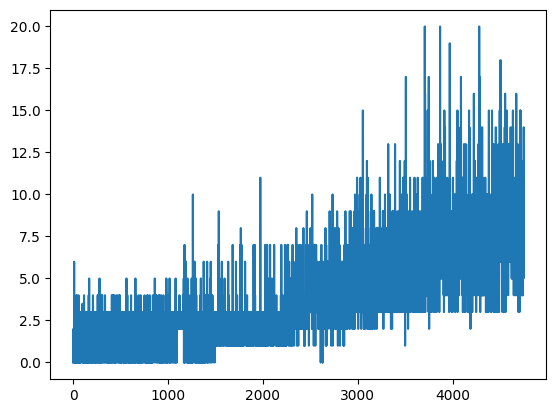

In [31]:
plt.plot(np.arange(len(ppo2.metrics['episode_rewards'])), ppo2.metrics['episode_rewards'])
plt.show()

In [36]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparams = {
    'n_envs': 24,
    'n_steps': 128,
    'epoch': 4,
    'num_mini_batch': 4,
    'gamma': 0.99,
    'lmbda': 0.95,
    'learning_rate': 1e-6,
    'eps_clip': 0.2,
    'value_coef': 0.5,
    'entropy_coef': 0.01,
    'total_timesteps': 1000000
}

hyperparams['mini_batch_size'] = hyperparams['n_envs'] * hyperparams['n_steps'] // hyperparams['num_mini_batch']

env_name = "BreakoutNoFrameskip-v4"

envs = gym.vector.SyncVectorEnv([make_env(env_name, 1+i) for i in range(hyperparams['n_envs'])])
cfg = Config()
in_chans = [4, 16, 32]
out_chans = [16, 32, 32]
actions_s = envs.single_action_space.n
model = PolicyAndValueFunction(cfg, in_chans, out_chans, actions_s).to(device)

loss = PPOLoss(hyperparams['value_coef'], hyperparams['entropy_coef']).to(device)

obs_shape = envs.single_observation_space.shape
act_shape = envs.single_action_space.shape
storage = PPOStorage(hyperparams['n_steps'], hyperparams['n_envs'], obs_shape, act_shape)

optm = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'], eps=1e-5)

ppo = PPO(envs, model, storage, loss, optm,
          hyperparams['n_steps'], hyperparams['n_envs'],
          hyperparams['total_timesteps'], hyperparams['epoch'],
          hyperparams['mini_batch_size'], device, lr=hyperparams['learning_rate'], clip_val=True)

In [37]:
ppo.train()

0.0 % completed


<ipython-input-15-dd4d1e5b0ae8>:30: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  self.dones_b[self.steps] = torch.Tensor(dones).to(self.device)


Streaming output truncated to the last 5000 lines.
Entropy:  tensor(1.3461, device='cuda:0', grad_fn=<MeanBackward0>)
Value Func. Explained Var.:  tensor(21.6418, device='cuda:0')
Adv. Mean:  tensor(0.0028, device='cuda:0')
Adv. Std.:  tensor(0.1807, device='cuda:0')
Avg. Rewards (last 40): 1.675


Clip Loss: tensor(-0.0079, device='cuda:0', grad_fn=<NegBackward0>) Value Loss: tensor(0.0170, device='cuda:0', grad_fn=<MulBackward0>) Entropy Loss: tensor(1.3461, device='cuda:0', grad_fn=<MeanBackward0>)
Global Step:  915456
Clipped Ratio:  0.0
Approx. KL:  tensor(1.2154e-07, device='cuda:0')
Entropy:  tensor(1.3462, device='cuda:0', grad_fn=<MeanBackward0>)
Value Func. Explained Var.:  tensor(25.1185, device='cuda:0')
Adv. Mean:  tensor(0.0028, device='cuda:0')
Adv. Std.:  tensor(0.1807, device='cuda:0')
Avg. Rewards (last 40): 1.675


Clip Loss: tensor(-0.0278, device='cuda:0', grad_fn=<NegBackward0>) Value Loss: tensor(0.0150, device='cuda:0', grad_fn=<MulBackward0>) Entropy Loss: tens

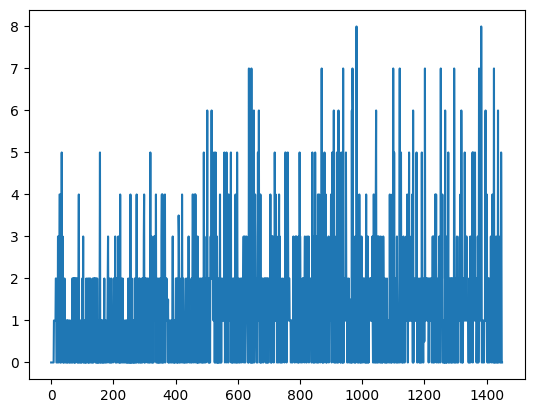

In [38]:
plt.plot(np.arange(len(ppo.metrics['episode_rewards'])), ppo.metrics['episode_rewards'])
plt.show()